In [1]:
import scipy as SP
import pylab as PL
%matplotlib inline
import glob
import h5py
import cPickle
def cl(f): return cPickle.load(open(f,'rb'))

In [2]:
expr, feat = cl("expr1024.pickle"), cl("feat1024.pickle")

## Feature aggregates across images

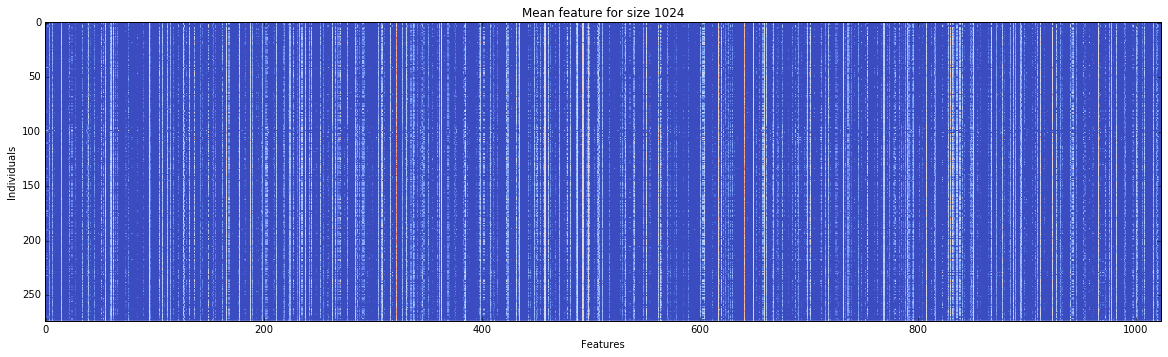

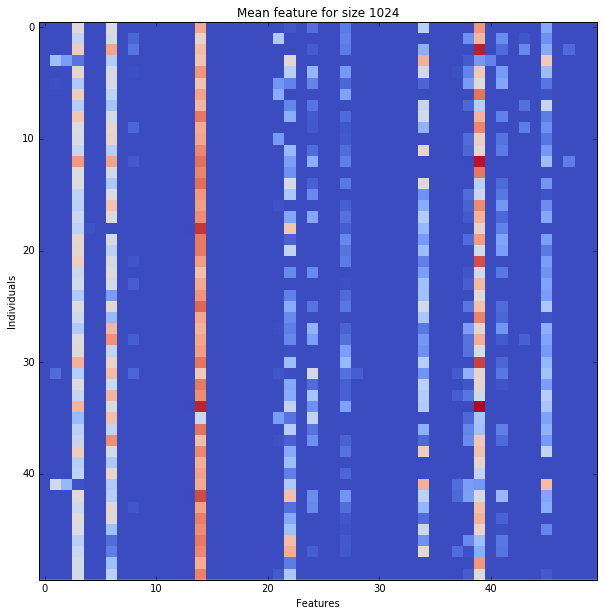

In [75]:
PL.figure(None,[20,20])
PL.imshow(feat, interpolation="None", cmap=PL.get_cmap("coolwarm"))
PL.title("Mean feature for size 1024")
PL.xlabel("Features"); PL.ylabel("Individuals")
PL.figure(None,[10,10])
PL.imshow(feat[0:50,0:50], interpolation="None", cmap=PL.get_cmap("coolwarm"))
PL.title("Mean feature for size 1024")
PL.xlabel("Features"); PL.ylabel("Individuals")


This looks similar to patches across image. Some features are higher and more variable, most are not active.

## Distributions of feature and expression means and variances

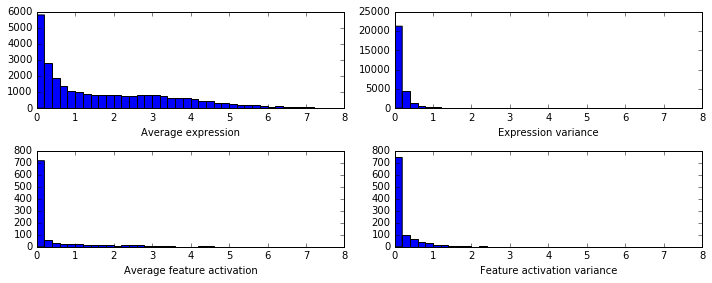

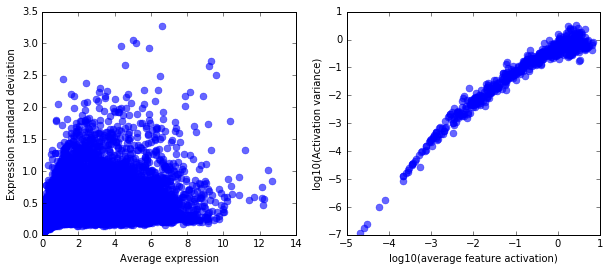

In [42]:
PL.figure(None, [10,4])
PL.subplot(221); PL.hist(expr.mean(axis=0), bins=40, range=(0,8)); PL.xlabel("Average expression")
PL.subplot(222); PL.hist(expr.var(axis=0),  bins=40, range=(0,8)); PL.xlabel("Expression variance")
PL.subplot(223); PL.hist(feat.mean(axis=0), bins=40, range=(0,8)); PL.xlabel("Average feature activation")
PL.subplot(224); PL.hist(feat.var(axis=0),  bins=40, range=(0,8)); PL.xlabel("Feature activation variance")
PL.tight_layout()
PL.figure(None,[10,4])
PL.subplot(121); 
PL.plot(expr.mean(axis=0), expr.var(axis=0)**0.5, ".", alpha=0.6, markersize=14)
PL.xlabel("Average expression"); PL.ylabel("Expression standard deviation")
PL.subplot(122); 
PL.plot(SP.log10(feat.mean(axis=0)), SP.log10(feat.var(axis=0)), ".", alpha=0.6, markersize=14)
PL.xlabel("log10(average feature activation)"); PL.ylabel("log10(Activation variance)")

Small numbers of genes are higly variable or expressed. Similarly, less than 30% of features are variable or active.

## Dimensionality reduction for genes and features

42 PCs needed for features, and 134 for expression to explain 0.995 of variance


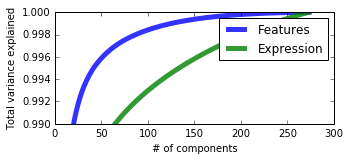

In [97]:
from sklearn.decomposition import PCA
PL.figure(None,[5,2])
pca = PCA()
explained_threshold = 0.995

pca.fit(feat.T)
fpc = pca.components_.copy()
varexpl = SP.cumsum(pca.explained_variance_ratio_)
Nf = SP.where(varexpl > explained_threshold)[0][0]
PL.plot(varexpl, linewidth=5, alpha=0.8)

pca.fit(expr.T)
epc = pca.components_.copy()
varexpl = SP.cumsum(pca.explained_variance_ratio_)
Ne = SP.where(varexpl > explained_threshold)[0][0]
PL.plot(varexpl, linewidth=5, alpha=0.8)
PL.xlabel("# of components"); PL.ylabel("Total variance explained")
PL.legend(["Features", "Expression"])
PL.ylim(0.99,1)

print "%d PCs needed for features, and %d for expression to explain %.3f of variance"%(Nf, Ne, explained_threshold)

A small number of components explain most of variance. We can use these for association tests. Also, we pick the top most expressed or variable genes and features, and associate them directly.

## PC to PC correlations

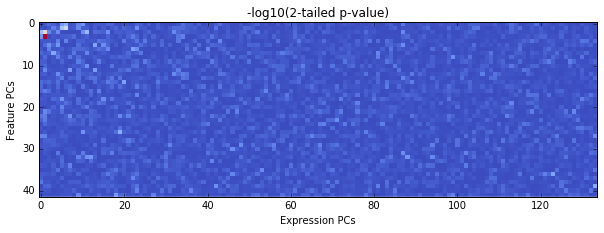

In [96]:
import scipy.stats as ST
logpvals = SP.zeros([Nf,Ne])

for i in range(Nf):
    for j in range(Ne):
        logpvals[i,j] = -SP.log10(ST.pearsonr(fpc[i], epc[j])[1]) # [0 is R, 1 is pvalue]
        
PL.figure(None, [10,5])
PL.imshow(logpvals, interpolation='none', cmap=PL.get_cmap("coolwarm"))
PL.ylabel("Feature PCs"); PL.xlabel("Expression PCs"); PL.title("-log10(2-tailed p-value)")

There seems to be more colour in the top left, where the components explaining most variance are. Zooming in.

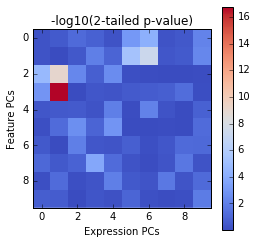

In [95]:
PL.figure(None, [4,4])
PL.imshow(logpvals[0:10,0:10], interpolation='none', cmap=PL.get_cmap("coolwarm"))
PL.ylabel("Feature PCs"); PL.xlabel("Expression PCs"); PL.title("-log10(2-tailed p-value)")
PL.colorbar()

This looks like a strong signal between expression PC 1 and feature PC 3. 


## Scatter plot of strongest association between PCs
Everything below survives Bonferroni correction for ~5600 tests.

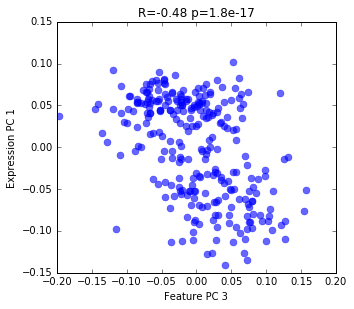

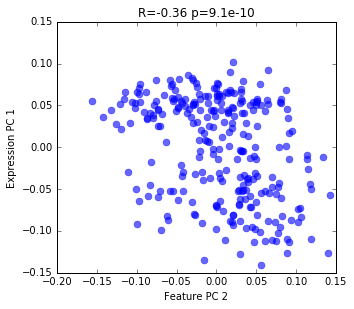

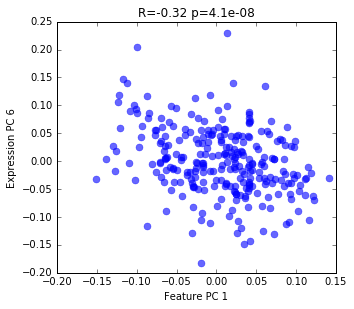

In [90]:
pairs = [(3,1),(2,1),(1,6)]
for f,e in pairs:
    PL.figure(None,[5,4.5])
    PL.plot(fpc[f], epc[e], ".", markersize=14, alpha=0.6)
    PL.title("R=%.2f p=%.1e"%(ST.pearsonr(fpc[f], epc[e])))
    PL.xlabel("Feature PC %d"%f); PL.ylabel("Expression PC %d"%e)

## Associations between most variable and most expressed genes, and most variable features

538 pairs with p < 10^(-6) (Bonferroni-significant at p=0.01)


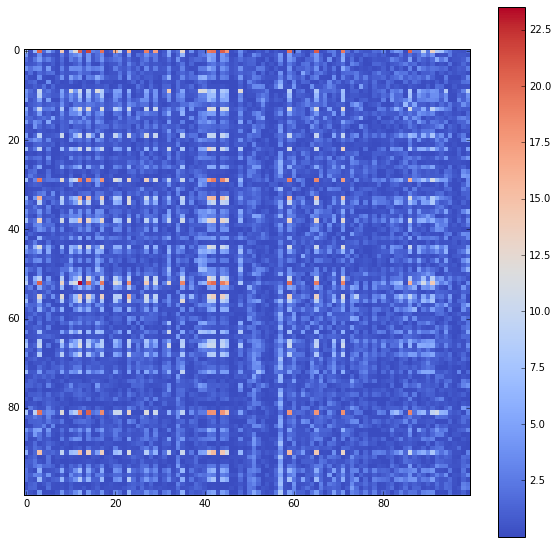

In [117]:
N = 100 # take 100 most variable features, 50 most expressed genes, 50 most variable genes, and look for associations
vars = feat.var(axis=0)
Ifeat = SP.argsort(feat.var(axis=0))[-N:]
Iexpr = list(SP.argsort(expr.var(axis=0))[-N/2:]) + list(SP.argsort(expr.mean(axis=0))[-N/2:])
logpvals = SP.zeros([N,N])
for i in range(N):
    for j in range(N):
        logpvals[i,j] = -SP.log10(ST.pearsonr(feat[:,Ifeat[i]], expr[:,Iexpr[j]])[1])

PL.figure(None, [10,9.5])
PL.imshow(logpvals, interpolation='none', cmap=PL.get_cmap("coolwarm"))
PL.colorbar()
print "%d pairs with p < 10^(-6) (Bonferroni-significant at p=0.01)"%((logpvals > 6).sum())

There seems to be correlations again! Going through all individual pairs that survive Bonferroni:
## Association scatter plots of individual gene-feature pairs

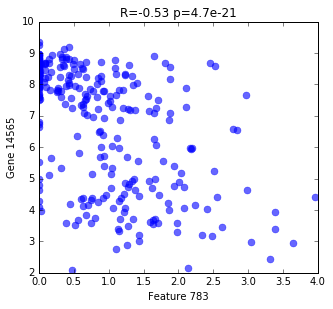

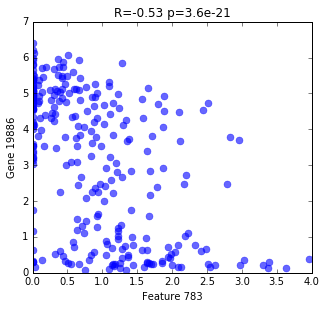

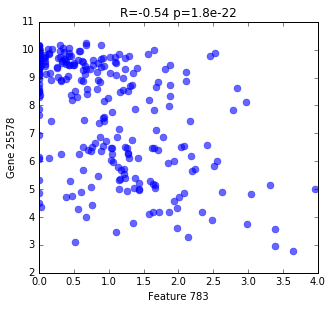

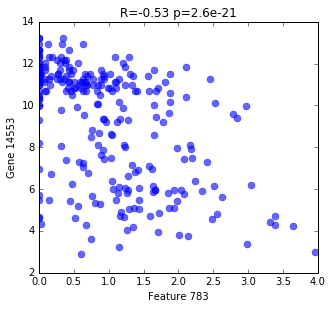

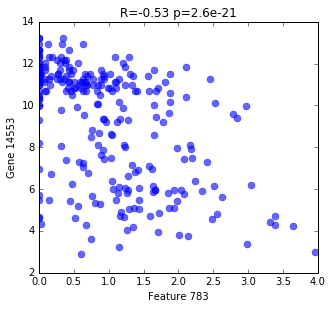

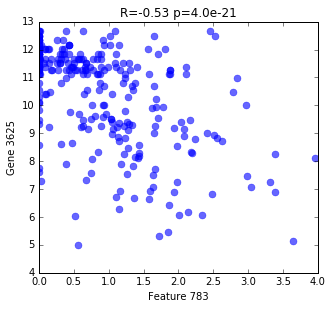

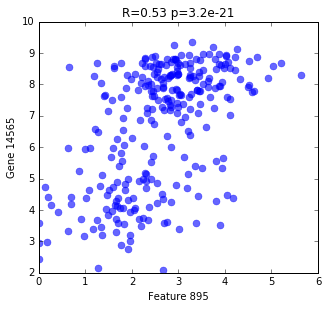

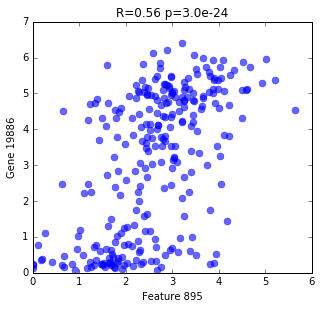

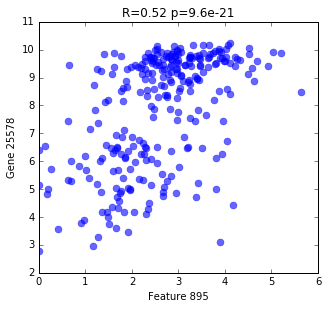

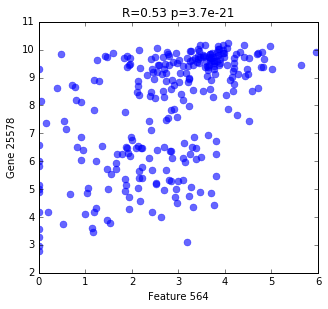

In [119]:
for i in range(N):
    for j in range(N):
        if logpvals[i,j] > 20: # 4 from Bonferroni, 2 from nominal; keeping limit 20 for now to make fewer plots
            PL.figure(None,[5,4.5])
            x,y = feat[:,Ifeat[i]], expr[:,Iexpr[j]]
            PL.plot(x, y, ".", markersize=14, alpha=0.6)
            PL.title("R=%.2f p=%.1e"%(ST.pearsonr(x,y)))
            PL.xlabel("Feature %d"%(Ifeat[i])); PL.ylabel("Gene %d"%(Iexpr[j]))